<a href="https://colab.research.google.com/github/Archibasov-D/nanolab_optimization_Multiplexer/blob/main/%D0%9E%D0%BF%D1%82%D0%B8%D0%BC%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%BB%D0%B0%D0%B1%D0%B0_%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%8F2_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numba import jit, njit, vectorize, cuda
from scipy.linalg import dft
import torch
import scipy as sp
from scipy.optimize import minimize
from PIL import Image, ImageChops

In [ ]:
# определение матрицы
# Фурье 250 на 250 точек - все размеры от сюда
# Для 150х150 работает - уже хорошо
wave_length = 1500 * 1e-9
N1 = 150
N2 = 150
T = 2*wave_length
k_wave = 2*np.pi/wave_length
d = 350*wave_length#350*wave_length
####################
N1_signal = 40
N2_signal = 40

n1_s_start = 110
n2_s_start = 54
####################
T_eye_enter = np.ones((N1,N2))
T_eye_enter[n1_s_start : (n1_s_start + N1_signal) , n2_s_start : (n2_s_start + N2_signal)] = 0

T_eye_out = np.identity(N1) - np.flip(T_eye_enter, axis =0)

parameter_vector= np.zeros((N1*N2, 1),dtype='complex') #<- вектор N1*N2


In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda')

In [ ]:
# расчёт матрицы B
def intermediate_matrix_calculation_for_B(T_eye_enter_f):
  #нужно описать пропогаторы
  #получение фурье матрицы
  T1 = np.multiply(np.ones((N1,N2)), np.flip(T_eye_enter_f, axis =0)) # T1 - это низ короба
  # определение пропогатора
  fX = np.fft.fftfreq(N1,T) #fY идентичны
  fY = fX.copy()
  H_propogator_d=np.zeros((N1,N2),dtype='complex')
  for i in range(N1):
    for j in range(N2):
      H_propogator_d[i,j] = np.exp(1j*k_wave*d*np.sqrt(1-np.power(wave_length*fX[j],2)-np.power(wave_length*fY[i],2)))
  #####отправляем это всё на GPU
  W = torch.Tensor(dft(N1)).to(device=device)
  W_rev = torch.Tensor(inv(dft(N1))).to(device=device)
  T1_vec_diag = torch.Tensor(np.diag(np.reshape(T1,(N1*N2)))).to(device=device)
  H_vec_diag = torch.Tensor(np.diag(np.reshape(H_propogator_d,(N1*N2)))).to(device=device)
  WW = torch.kron(W,W)
  W_rW_r = torch.kron(W_rev,W_rev)
  B = torch.matmul(W_rW_r,torch.matmul(H_vec_diag,torch.matmul(WW,torch.matmul(T1_vec_diag, torch.matmul( W_rW_r, torch.matmul(H_vec_diag, WW))))))
  return B

In [ ]:
B = intermediate_matrix_calculation_for_B(T_eye_enter)

<ipython-input-5-fb6ef2f26a86>:14: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:305.)
  W = torch.Tensor(dft(N1)).to(device=device)


In [ ]:
# вычисление T0
def T0_vec_diag_calculation(parameter_): #      <- вектор
  T0 = np.multiply(np.exp(1j*np.reshape(parameter_,(N1,N2))), T_eye_enter)
  T0_vec_diag = torch.Tensor(np.diag(np.reshape(T0,(N1*N2)))).to(device=device)
  return T0_vec_diag

In [ ]:
T0_vec_diag = T0_vec_diag_calculation(parameter_vector)
A = torch.matmul(T0_vec_diag,B).to(device=device)

In [ ]:
I = torch.Tensor(np.reshape(np.ones((N1,N1)),(N1*N2))).to(device=device) ########
Uk = torch.reshape(torch.matmul(A, I),(N1,N2))
del I

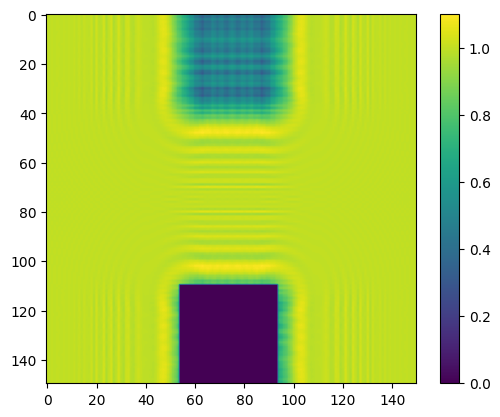

In [ ]:
plt.imshow(np.absolute(Uk.cpu()))
plt.colorbar()
plt.show()

In [ ]:
#################################################################
#################################################################

In [ ]:
#нужно задать начальное и таргетовое поле

In [ ]:
############
############
############
############
############
############

In [ ]:
img = np.array(Image.open('mode_1.png').convert('L'))



U_initial = np.array(ImageChops.invert(Image.open('mode_1.png')).convert('L').resize((N1_signal,N2_signal)))/250                      #np.reshape(np.ones((N1_signal, N2_signal)), ((N1_signal*N2_signal,1)))     #
U_target  = np.array(ImageChops.invert(Image.open('mode_2.png')).convert('L').resize((N1_signal,N2_signal)))/250                    #np.reshape(np.ones((N1_signal, N2_signal)), ((N1_signal*N2_signal,1)))     #

U_initial_full_size = np.zeros((N1, N2))
U_initial_full_size[n1_s_start : (n1_s_start + N1_signal) , n2_s_start : (n2_s_start + N2_signal)] = U_initial

U_target_full_size = np.zeros((N1, N2))
#U_target_full_size[N1 - n1_s_start - 1 : (N1 - n1_s_start - 1 + N1_signal) , n2_s_start : (n2_s_start + N2_signal)] = U_target      #????

U_target_full_size[n1_s_start : (n1_s_start + N1_signal) , n2_s_start : (n2_s_start + N2_signal)] = U_target

U_target_full_size = np.flip(U_target_full_size, axis =0) #МОЖЕТ ВОЗНИКНУТЬ ОШИБКА !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

del U_initial, U_target

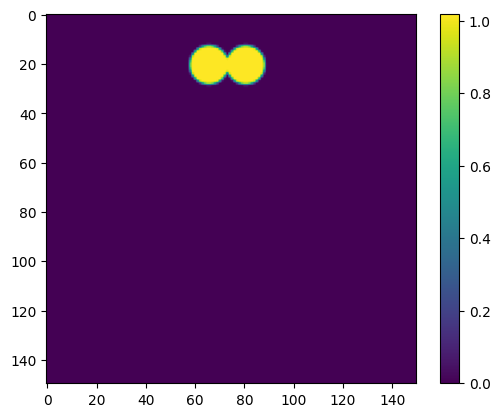

In [ ]:
plt.imshow(U_target_full_size)
plt.colorbar()
plt.show()

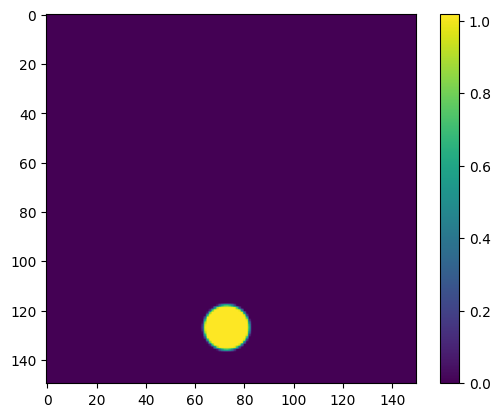

In [ ]:
plt.imshow(U_initial_full_size)
plt.colorbar()
plt.show()

In [ ]:
def overlap_integral( U_): #на случай одной пары - для минимазации, полноразмерные векторы
  return -np.absolute(np.matmul(np.conj(np.reshape(U_target_full_size,(N1*N2))).T, U_))**2

In [ ]:
def grad_overlap_integral(U_):# <- векторные вычисления, можно большой размерности передавать, вектор U_target_ - будет из нулей создавать
  U_ = np.multiply(U_, np.reshape(T_eye_enter,((N1*N2),1)))        #зануление градиента для входного отверстия
  V = torch.matmul(torch.conj(torch.t(A)),torch.Tensor(np.reshape(U_target_full_size,(N1*N2))).to(device=device))
  return 2*np.imag( np.conjugate(np.matmul(np.conj(np.reshape(U_target_full_size,(N1*N2))).T, U_))*np.multiply(np.conjugate(V.cpu()),U_) )

In [ ]:
bnds = ((0, 2*np.pi),)*(N1*N2)

In [ ]:
print(bnds)

((0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307

In [ ]:
#x0 - parameter_matrix_phase
minimize(overlap_integral, np.reshape(parameter_vector,((N1*N2))), method='BFGS', bounds=bnds, jac=grad_overlap_integral, options={'gtol': 1e-6,'maxiter' : 1000})

<ipython-input-22-efbb143d39b7>:2: RuntimeWarning: Method BFGS cannot handle bounds.
  minimize(overlap_integral, np.reshape(parameter_vector,((N1*N2))), method='BFGS', bounds=bnds, jac=grad_overlap_integral, options={'gtol': 1e-6,'maxiter' : 1000})
/usr/local/lib/python3.10/dist-packages/scipy/_lib/array_api_compat/common/_aliases.py:235: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype=dtype, copy=copy)


In [ ]:
def vector_p_to_matrix(p): # МОЖЕТ ПРИГОДИТЬСЯ ДЛЯ ПОСТРОЕНИЯ ГРАФИКОВ ?????
  #всего в векторе N1*N2 - N1_signal*N2_signal значений
  #1 этап
  intermediate_array=np.zeros((N1*N2, 1))
  intermediate_array[0:N1,0:n2_s_start] = np.reshape(p[0:(N1*n2_s_start)],(N1,n2_s_start))
  #2 этап
  k=1
  l=0
  for j in range(n2_s_start, n2_s_start + N2_signal):
    #k
    intermediate_array[0:n1_s_start, j] = np.reshape(p[(N1*n2_s_start + n1_s_start*(k-1) + (N1-n1_s_start - N1_signal)*(l-1)):(N1*n2_s_start + n1_s_start*k + (N1-n1_s_start - N1_signal)*l)],(n1_s_start,1))
    k=k+1
    #l
    intermediate_array[(n1_s_start+N1_signal):N1, j] = np.reshape(p[(N1*n2_s_start + n1_s_start*(k-1) + (N1-n1_s_start - N1_signal)*(l-1)):(N1*n2_s_start + n1_s_start*k + (N1-n1_s_start - N1_signal)*l)],((N1-n1_s_start - N1_signal),1))
    l=l+1
  #3 этап
  intermediate_array[0:N1,n2_s_start+N2_signal:N2] = np.reshape(p[(N1*(n2_s_start+N2_signal) - N1_signal*N2_signal):(N1*N2)],(N1,(N2-n2_s_start-N2_signal)))
  return intermediate_array.copy()
